## Implementing modern Transformers

#### Pre-Trained Transformer models for language modelling (used in LLMs) are decoder-only architectures performing successive transformations of the input tokens by a sequence of causal multihead self-attention and feed-forward sub-layers, intertwined with normalization blocks and residual routing mechanisms.

<p align="center">
      <td align="center"><img src="../illus/tiny_llama_bg.png" width="750"/></td>
</p>

## We will now go over the steps of building one from scratch

#### The embedding layer:
Its purpose is to map integer token IDs into a vector space of the desired embedding dimension of your model  

In [28]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

class Embedding(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int, device: torch.device = None, dtype: torch.dtype = None):
        super().__init__()
        self.num_embeddings = num_embeddings # The vocab size
        self.embedding_dim = embedding_dim

        embedding_matrix = torch.empty(self.num_embeddings,
                                       self.embedding_dim,
                                       device=device,
                                       dtype=dtype)

        nn.init.trunc_normal_(embedding_matrix,
                              mean=0.,
                              std=1.,
                              a=-3,
                              b=3)

        self.embedding_matrix = nn.Parameter(embedding_matrix)

    def forward(self, x: torch.LongTensor):
        """ Maps token IDs to a vector space of dim d_model """

        # x shape : [batch_size, seq_len]
        # W shape : [vocab_size, d_model]
        return self.embedding_matrix[x]

In [17]:
torch.manual_seed(0)
batch_size = 1
vocab_size = 1000
sequence_length = 5
d_model=8

x = torch.randint(low=0, high=vocab_size, size=(batch_size, sequence_length,))
embedding = Embedding(num_embeddings=vocab_size, embedding_dim=d_model)
embedded = embedding(x)
print(x)
print(embedded[0])

tensor([[ 44, 239, 933, 760, 963]])
tensor([[ 0.6530, -1.0291,  0.2862, -0.9838, -2.4061, -1.2841,  1.2463,  0.7381],
        [ 0.3677,  0.5190,  1.1595, -0.3934, -0.7742, -0.0980,  1.2264,  0.1077],
        [-0.5595, -0.7555,  0.2039, -0.4311,  0.6812, -1.3817, -0.9745,  1.5133],
        [-0.7261,  0.5956, -0.1099,  0.5234,  0.3712, -0.3936,  0.1740, -0.1932],
        [ 0.1596,  0.0548, -0.9889, -2.0569,  0.3137, -0.3510,  0.2530, -0.2767]],
       grad_fn=<SelectBackward0>)


#### The normalization layer:
In modern architectures, RMSNorm [(Zhang & Sennrich, 2019)](https://arxiv.org/pdf/1910.07467) is a common choice. As a form of so-called Layer Normalization, it normalizes the token representations. Notice that as opposed to the original architecture by [Vaswani et al., 2017](https://arxiv.org/pdf/1706.03762), modern architectures tend to favor pre-normalization (before the sub-layers) instead of post-normalization (after the sub-layers).

Given a token representation $x \in \mathbb{R}^{d_{\mathrm{model}}}$, we rescale each entry $x_i$ as 
$$ \tilde{x_i} = \frac{x_i}{\sqrt{\frac{1}{d_{\mathrm{model}}}\sum^{d_{\mathrm{model}}}_{i=1} x_i^2 + \epsilon}} g_i$$

where $g_i$ is a trainable parameter (called the gain).

In [18]:
class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5, device: torch.device = None, dtype: torch.dtype = None):
        super().__init__()
        self.eps = eps
        self.d_model = d_model
        self.gain = nn.Parameter(torch.ones(d_model,
                                            device=device,
                                            dtype=dtype))

    def forward(self, x: torch.Tensor):

        # x shape [batch_size, seq_len, d_model]

        # Training is typically done in bfloat16, we upscale it to torch.float32 here for stability
        in_dtype = x.dtype
        x = x.to(torch.float32)

        normalized = x * torch.rsqrt(torch.sum(x**2, dim=-1, keepdim=True) / self.d_model + self.eps)

        return (normalized * self.gain).to(in_dtype)

In [22]:
rms_norm = RMSNorm(d_model=d_model)
normalized = rms_norm(embedded)

#### The positional encoding

In modern architectures, Rotary Positional Encoding [(Su et al., 2024)](https://arxiv.org/pdf/2104.09864) is a common choice. Its role is to break the permutation equivarience of the architecture, and exploit the relative distance between pairs of token representations in the self-attention process. It is only applied to the Query and Key representations.

The presentation will be done on board.

In [23]:
class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, theta: float, d_k: int, max_seq_len: int, device: torch.device = None):
        super().__init__()

        thetas = 1 / theta**((2*torch.arange(int(d_k//2)) / d_k))
        positions = torch.arange(max_seq_len)
        angles = torch.outer(positions, thetas)

        cos_sin_matrix = torch.polar(torch.ones_like(angles), angles).to(device)
        self.register_buffer("cos_sin_matrix",
                             cos_sin_matrix,
                             persistent=False)
    def forward(self, x: torch.Tensor, token_positions: torch.Tensor):

        # x shape [..., seq_len, model_dim]

        x_complex = torch.view_as_complex(x.reshape(*x.shape[:-1], -1, 2))
        rots = self.cos_sin_matrix[token_positions]
        roted = torch.einsum('...ij,...ij->...ij', x_complex, rots)
        encoded = torch.view_as_real(roted).reshape(*x.shape)

        return encoded

#### Causal Multihead Self-Attention sublayer

This is the exact same mechanism as in [Vaswani et al., 2017](https://arxiv.org/pdf/1706.03762) ! (modulo the Rotary Positional Encoding) The goal is to confer to the model a mechanism to relate pairs of token representations (modelled by Queries and Keys) to each other and learn how to exploit their similarity (more on the board).

Behold the celebrated expression (in row-vector representation): 

$$ \mathrm{Attention}(Q_i, K_i, V_i) = \mathrm{softmax}(\frac{Q_i K_i^\top}{d_{\mathrm{head}}}) V_i \quad \forall i \in [n_{\mathrm{heads}}]$$

In [25]:
class LinearNoBias(nn.Module):
    def __init__(self, in_features: int, out_features: int, device=None, dtype=None):
        super().__init__()

        weights = torch.empty(out_features, in_features,
                              dtype=dtype, device=device)
        std = math.sqrt(2/(in_features+out_features))
        nn.init.trunc_normal_(weights,
                              mean=0.,
                              std=std,
                              a=-3*std,
                              b=3*std)

        self.weights = nn.Parameter(weights)

    def forward(self, x: torch.Tensor):
        """ Apply linear transformation to the input """

        return torch.einsum('...j, ij -> ...i', x, self.weights)

class Softmax(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor, dim: int):
        safe = x - torch.max(x, dim, keepdim=True)[0]
        exped = torch.exp(safe)
        return exped / torch.sum(exped, dim=dim, keepdim=True)

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

        self.softmax = Softmax()

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, causal_mask: torch.Tensor = None):
        """ Compute softmax(QK.T / d_k)V """

        # Q: [batch_size, d_head, seq_len, d_k]
        # K: [batch_size, d_head, seq_len, d_k]
        # V: [batch_size, d_head, seq_len, d_v]

        d_k = K.shape[-1]

        scores = torch.einsum('b...qd,b...kd->b...qk', Q, K) / math.sqrt(d_k)

        if causal_mask is not None:
            scores = scores.masked_fill_(causal_mask == False, -torch.inf)

        probs = self.softmax(scores, dim=-1)
        return torch.einsum('b...qk,b...kd->b...qd', probs, V)


class CausalMultiheadSelfAttention(nn.Module):
    def __init__(self, d_model: int,
                 n_heads: int,
                 rpe: bool = False,
                 max_seq_len: int = None,
                 theta: float = None,
                 device: torch.device = None):
        super().__init__()

        self.rpe = rpe

        self.n_heads = n_heads

        self.dim_heads = int(d_model // self.n_heads)

        # Linear transforms
        self.w_q = LinearNoBias(in_features=d_model,
                                out_features=self.n_heads*self.dim_heads, device=device)
        self.w_k = LinearNoBias(in_features=d_model,
                                out_features=self.n_heads*self.dim_heads, device=device)
        self.w_v = LinearNoBias(in_features=d_model,
                                out_features=self.n_heads*self.dim_heads, device=device)
        self.w_o = LinearNoBias(in_features=self.n_heads *
                                self.dim_heads, out_features=d_model, device=device)

        # Rot. Positional encoding
        if self.rpe:
            self.rope = RotaryPositionalEmbedding(
                d_k=self.dim_heads,
                max_seq_len=max_seq_len,
                theta=theta,
                device=device)

        self.compute_attention = ScaledDotProductAttention()

    def forward(self, x: torch.Tensor, token_positions: torch.Tensor = None):

        # x shape [batch_size, seq_len, d_model]
        seq_len = x.shape[-2]

        # Form Queries, Keys and Values
        Q = self.w_q(x)  # shape [batch_size, seq_len, n_heads*dim_heads]
        K = self.w_k(x)
        V = self.w_v(x)

        # Separate the heads
        Q = Q.reshape(*Q.shape[:-1], self.n_heads, self.dim_heads) # shape [batch_size, seq_len, n_heads, dim_heads]
        K = K.reshape(*K.shape[:-1], self.n_heads, self.dim_heads)
        V = V.reshape(*V.shape[:-1], self.n_heads, self.dim_heads)

        # Move the head dimension before the seq_len dimension
        Q = Q.transpose(-2, -3) # shape [batch_size, n_heads, seq_len, dim_heads]
        K = K.transpose(-2, -3)
        V = V.transpose(-2, -3)

        # Apply RPE to Qs and Ks
        if self.rpe:
            Q = self.rope(Q, token_positions)
            K = self.rope(K, token_positions)

        # Create causal mask
        causal_mask = torch.tril(torch.ones(seq_len, seq_len))

        # Compute each head's attention with causal masking
        head_attentions = self.compute_attention(Q, K, V, causal_mask)

        # Reshape and concatenate the head outputs
        head_attentions = head_attentions.transpose(-2, -3) # shape [batch_size, seq_len, n_heads, dim_heads]
        head_attentions = head_attentions.reshape(*head_attentions.shape[:-2], -1) # shape [batch_size, seq_len, dim_model]

        # Transform the head outputs
        out = self.w_o(head_attentions)

        return out

#### The Feedforward sublayer

In some modern architectures like LLaMA [(Touvron et al., 2023)](https://arxiv.org/pdf/2302.13971), Mistral [(Jiang et al., 2023)](https://arxiv.org/pdf/2310.06825) or Qwen [(Yang et al., 2024)](https://arxiv.org/pdf/2412.15115), SwiGLU is a common choice following observations by [Shazeer, 2020](https://arxiv.org/abs/2002.05202) that they empirically improve the performance of Transformers over standard ReLU networks with the famous quote in the conclusion

<p align="center">
      "We offer no explanation as to why these architectures seem to work; we attribute their success, as all else, to divine benevolence."
</p>


It is defined as a combination of Gated Linear Units (GLU) [(Dauphin et al., 2017)](https://arxiv.org/abs/1612.08083) with the Swish activation function :

$$ \mathrm{SwiGLU}(x, W_1, W_2, W_3) = W_2 (\mathrm{Swish}(W_1 x) \odot W_3 x) $$

where $\mathrm{Swish}(x) = \frac{x}{1 + \mathrm{e}^{-x}}$

In [45]:
class SiLU(nn.Module):
    """ What ppl also call the Swish activation """
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(x)


class SwiGLU(nn.Module):
    def __init__(self, d_model: int, d_ff: int = None, device: torch.device = None, dtype: torch.dtype = None):
        super().__init__()

        # Canonically set to standard practice
        if d_ff:
            self.d_ff = d_ff
        else:
            self.d_ff = int(8 * d_model / 3)

        self.W1 = LinearNoBias(in_features=d_model, out_features=self.d_ff,
                               device=device, dtype=dtype)
        self.W2 = LinearNoBias(in_features=self.d_ff, out_features=d_model,
                               device=device, dtype=dtype)
        self.W3 = LinearNoBias(in_features=d_model, out_features=self.d_ff,
                               device=device, dtype=dtype)
        self.silu = SiLU()

    def forward(self, x: torch.Tensor):
        return self.W2(self.silu(self.W1(x)) * self.W3(x))

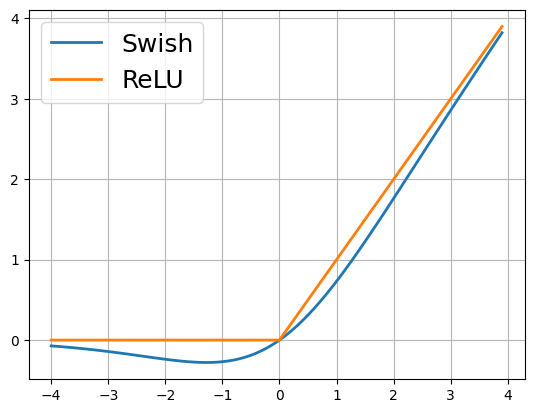

In [46]:
x = torch.arange(-4, 4, 0.1)
swish = SiLU()
relu = nn.ReLU()
plt.close('all')
plt.plot(x, swish(x), color='tab:blue', label="Swish", lw=2)
plt.plot(x, relu(x), color='tab:orange', label="ReLU", lw=2)
plt.grid(which="both", alpha=0.9)
plt.legend(fontsize=18)
plt.show()

### We now have all the pieces to assemble a LLaMA-like architecture for generative pre-training !

<p align="center">
      <td align="center"><img src="../illus/tiny_llama_bg.png" width="750"/></td>
</p>

#### 1. First, assemble the Transformer layer

In [47]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, max_seq_len: int, theta: float, device=None):
        super().__init__()

        self.feedforward = SwiGLU(d_model=d_model, d_ff=d_ff, device=device)

        self.mha = CausalMultiheadSelfAttention(
            d_model=d_model,
            n_heads=num_heads,
            rpe=True,
            max_seq_len=max_seq_len,
            theta=theta,
            device=device)

        self.norm_1 = RMSNorm(d_model=d_model, device=device)
        self.norm_2 = RMSNorm(d_model=d_model, device=device)

    def forward(self, x: torch.Tensor):

        # Pre-MHA normalization
        normed_x = self.norm_1(x)

        # Residual MHA sub-layer output
        token_positions = torch.arange(x.shape[-2])
        res_mha = x + self.mha(normed_x, token_positions=token_positions)

        # Pre-feedforward normalization
        normed_res_mha = self.norm_2(res_mha)

        # Residual FFW sub-layer output
        res_ffw = res_mha + self.feedforward(normed_res_mha)

        return res_ffw

#### 2. Then, assemble the complete decoder

In [48]:
class TransformerLM(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 context_length: int,
                 num_layers: int,
                 d_model: int,
                 num_heads: int,
                 d_ff: int,
                 theta: float,
                 device: torch.Tensor = None):
        super().__init__()

        self.embedding = Embedding(num_embeddings=vocab_size,
                                   embedding_dim=d_model, device=device)

        self.core_layers = nn.Sequential()
        for _ in range(num_layers):
            self.core_layers.append(TransformerBlock(
                d_model=d_model,
                num_heads=num_heads,
                d_ff=d_ff,
                max_seq_len=context_length,
                theta=theta,
                device=device))

        self.out_norm = RMSNorm(d_model=d_model, device=device)

        self.out_proj = LinearNoBias(
            in_features=d_model, out_features=vocab_size, device=device)

        # self.softmax = Softmax()

    def forward(self, x: torch.Tensor):

        embedded = self.embedding(x)

        transformed = self.core_layers(embedded)

        normed = self.out_norm(transformed)

        logits = self.out_proj(normed)

        # probs = self.softmax(logits, dim=-1)

        return logits

## That's it for implementing the model. Next week, we'll implement the training pipeline (Cross-entropy loss, AdamW optimizer, training loop) for end-to-end training of a small LLM